https://arxiv.org/pdf/1406.2661.pdf

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py


 Importing  libraries

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [19]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape

(60000, 28, 28)

 Reshaping the images to add one more dimension i.e Channel. As the images are gray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [20]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [22]:
train_images[56782, :10, :10]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [23]:
train_images = (train_images - 127.5) / 127.5

train_images[56782, :10, :10]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

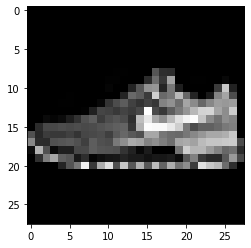

In [25]:
plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

Training set is prepared by dividing the whole data into batches and shuffling it.

In [26]:
buffer_size = 60000
batch_size = 128

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Dense layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then using Relu activations for each Dense layer.Note that activation in final layer is tanh which outputs in the range -1 to 1.
we reshape the 784-d tensor to (Batch Size, 28, 28, 1) using layers.Reshape function 

In [28]:
def generator_model():
   
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim = 100))
    model.add(layers.ReLU())
   
    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    
    model.add(layers.Dense(256))
    model.add(layers.ReLU()) 

    model.add(layers.Dense(784, activation = 'tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    
    return model

Building the generator model and summary is obtained

In [29]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

Using the (as yet untrained) generator to create an random gray scale image.

In [33]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 28, 28, 1])

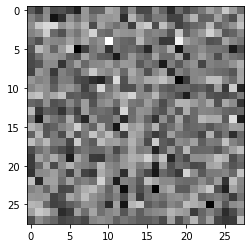

In [34]:
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

Note that the discriminator is a binary classifier, consisting  only of fully -connected layers. So, the discriminator expects a tensor of shape (Batch Size, 28, 28, 1). We are flattening out input to feed it into Dense layers. Each dense layer is having activation as LeakyRelu followed by drop out layers
The final layer has the sigmoid activation function, which squashes the output value between 0 (fake) and 1 (real).Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended).

In [40]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())
  
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [41]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_7 (Dropout)         (None, 128)              

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [42]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.46845508]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [43]:
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [44]:
def discriminator_loss(real_output, fake_output):
    
    real_loss = bce(tf.ones_like(real_output), real_output)

    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [45]:
def generator_loss(fake_output):

    gen_loss = bce(tf.ones_like(fake_output), fake_output)
  
    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.

In [46]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [49]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [50]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and plotting images is defined

In [51]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [53]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list =[]
    fake_score_list =[]
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)                 

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list              

Finally, it’s time to train our  GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real. 

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches...
Losses after epoch     1: generator 3.065, discriminator 0.250, real_score 92.71%, fake_score 7.93%


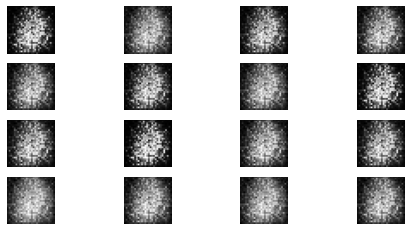

  2%|▏         | 1/50 [00:11<09:36, 11.77s/it]

Time for epoch 1 is 11.76858401298523 sec
Training started with  epoch 2 with 469 batches...
Losses after epoch     2: generator 3.308, discriminator 0.133, real_score 97.42%, fake_score 7.17%


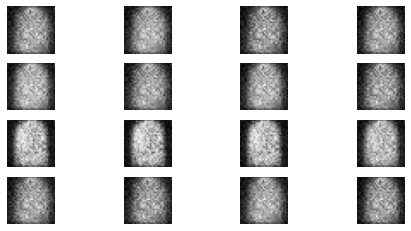

  4%|▍         | 2/50 [00:22<08:46, 10.97s/it]

Time for epoch 2 is 10.405967712402344 sec
Training started with  epoch 3 with 469 batches...
Losses after epoch     3: generator 3.795, discriminator 0.656, real_score 85.82%, fake_score 10.23%


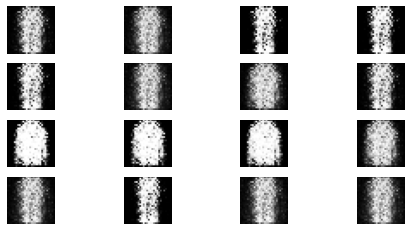

  6%|▌         | 3/50 [00:31<08:08, 10.38s/it]

Time for epoch 3 is 9.672299861907959 sec
Training started with  epoch 4 with 469 batches...
Losses after epoch     4: generator 2.129, discriminator 0.487, real_score 91.52%, fake_score 22.25%


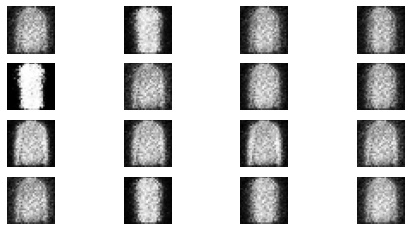

  8%|▊         | 4/50 [00:41<07:44, 10.09s/it]

Time for epoch 4 is 9.622116565704346 sec
Training started with  epoch 5 with 469 batches...
Losses after epoch     5: generator 2.826, discriminator 0.335, real_score 92.91%, fake_score 12.87%


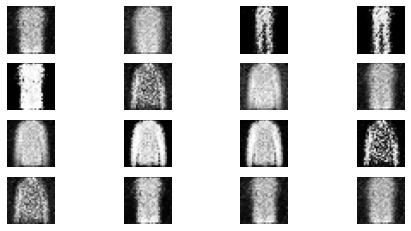

 10%|█         | 5/50 [00:51<07:29,  9.99s/it]

Time for epoch 5 is 9.82473635673523 sec
Training started with  epoch 6 with 469 batches...
Losses after epoch     6: generator 2.392, discriminator 0.282, real_score 92.53%, fake_score 11.26%


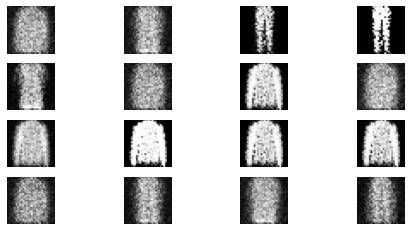

 12%|█▏        | 6/50 [01:00<07:13,  9.86s/it]

Time for epoch 6 is 9.586545705795288 sec
Training started with  epoch 7 with 469 batches...
Losses after epoch     7: generator 2.164, discriminator 0.454, real_score 89.61%, fake_score 21.05%


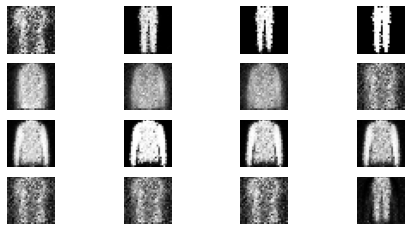

 14%|█▍        | 7/50 [01:11<07:07,  9.94s/it]

Time for epoch 7 is 10.109235286712646 sec
Training started with  epoch 8 with 469 batches...
Losses after epoch     8: generator 3.491, discriminator 0.324, real_score 89.77%, fake_score 7.78%


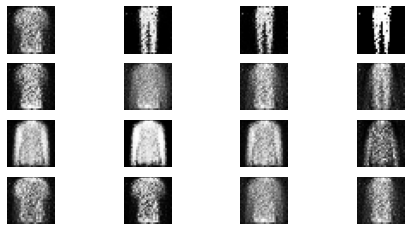

 16%|█▌        | 8/50 [01:20<06:52,  9.82s/it]

Time for epoch 8 is 9.572296142578125 sec
Training started with  epoch 9 with 469 batches...
Losses after epoch     9: generator 2.400, discriminator 0.496, real_score 84.05%, fake_score 16.96%


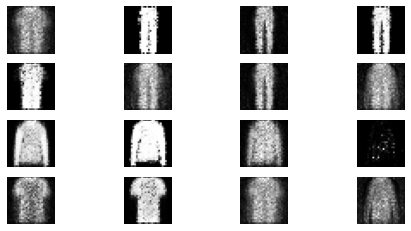

 18%|█▊        | 9/50 [01:30<06:42,  9.81s/it]

Time for epoch 9 is 9.764071226119995 sec
Training started with  epoch 10 with 469 batches...
Losses after epoch    10: generator 1.920, discriminator 0.681, real_score 76.98%, fake_score 21.64%


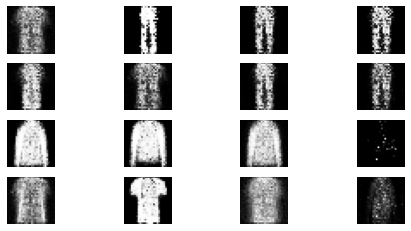

 20%|██        | 10/50 [01:39<06:28,  9.72s/it]

Time for epoch 10 is 9.516164541244507 sec
Training started with  epoch 11 with 469 batches...
Losses after epoch    11: generator 2.142, discriminator 0.515, real_score 84.26%, fake_score 18.98%


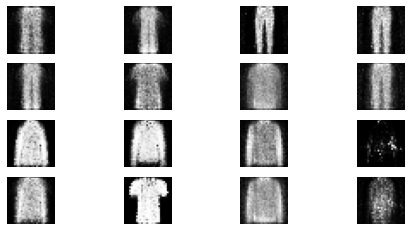

 22%|██▏       | 11/50 [01:49<06:15,  9.62s/it]

Time for epoch 11 is 9.390351295471191 sec
Training started with  epoch 12 with 469 batches...
Losses after epoch    12: generator 3.200, discriminator 0.363, real_score 87.23%, fake_score 11.75%


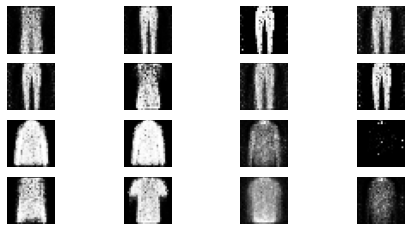

 24%|██▍       | 12/50 [01:59<06:07,  9.68s/it]

Time for epoch 12 is 9.81381893157959 sec
Training started with  epoch 13 with 469 batches...
Losses after epoch    13: generator 2.168, discriminator 0.549, real_score 87.40%, fake_score 22.04%


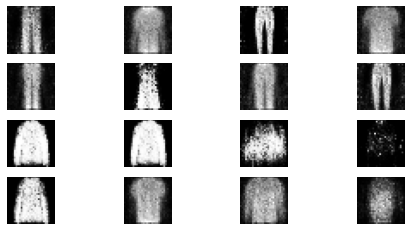

 26%|██▌       | 13/50 [02:08<05:56,  9.64s/it]

Time for epoch 13 is 9.538211107254028 sec
Training started with  epoch 14 with 469 batches...
Losses after epoch    14: generator 1.634, discriminator 0.849, real_score 73.74%, fake_score 26.47%


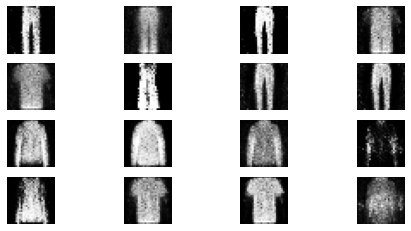

 28%|██▊       | 14/50 [02:18<05:47,  9.64s/it]

Time for epoch 14 is 9.649691820144653 sec
Training started with  epoch 15 with 469 batches...
Losses after epoch    15: generator 2.897, discriminator 0.358, real_score 85.45%, fake_score 10.39%


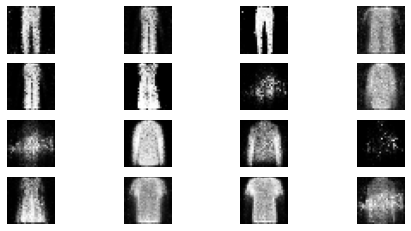

 30%|███       | 15/50 [02:27<05:37,  9.65s/it]

Time for epoch 15 is 9.644576787948608 sec
Training started with  epoch 16 with 469 batches...
Losses after epoch    16: generator 2.114, discriminator 0.665, real_score 78.01%, fake_score 20.16%


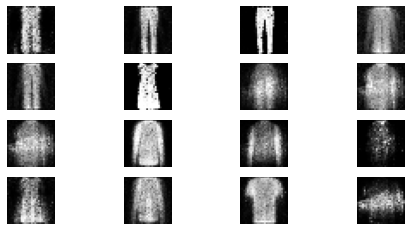

 32%|███▏      | 16/50 [02:38<05:41, 10.04s/it]

Time for epoch 16 is 10.939286947250366 sec
Training started with  epoch 17 with 469 batches...
Losses after epoch    17: generator 2.710, discriminator 0.658, real_score 79.49%, fake_score 18.18%


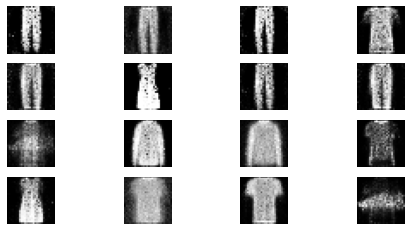

 34%|███▍      | 17/50 [02:48<05:24,  9.83s/it]

Time for epoch 17 is 9.33212661743164 sec
Training started with  epoch 18 with 469 batches...
Losses after epoch    18: generator 2.411, discriminator 0.574, real_score 84.08%, fake_score 18.98%


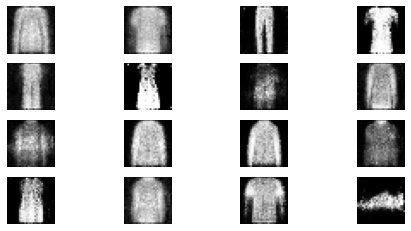

 36%|███▌      | 18/50 [02:57<05:13,  9.79s/it]

Time for epoch 18 is 9.685058355331421 sec
Training started with  epoch 19 with 469 batches...
Losses after epoch    19: generator 2.380, discriminator 0.676, real_score 78.16%, fake_score 19.07%


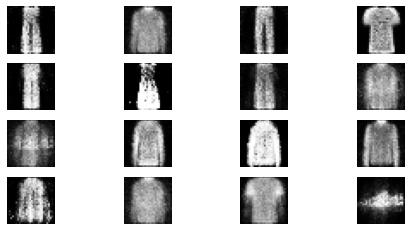

 38%|███▊      | 19/50 [03:07<05:00,  9.69s/it]

Time for epoch 19 is 9.436711549758911 sec
Training started with  epoch 20 with 469 batches...
Losses after epoch    20: generator 1.082, discriminator 1.118, real_score 66.92%, fake_score 39.81%


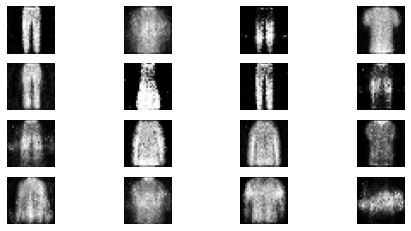

 40%|████      | 20/50 [03:17<04:51,  9.73s/it]

Time for epoch 20 is 9.836155891418457 sec
Training started with  epoch 21 with 469 batches...
Losses after epoch    21: generator 1.528, discriminator 0.952, real_score 73.13%, fake_score 29.46%


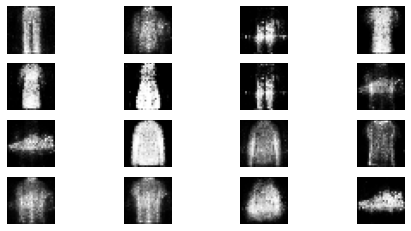

 42%|████▏     | 21/50 [03:26<04:38,  9.59s/it]

Time for epoch 21 is 9.257918357849121 sec
Training started with  epoch 22 with 469 batches...
Losses after epoch    22: generator 2.242, discriminator 0.555, real_score 86.05%, fake_score 20.19%


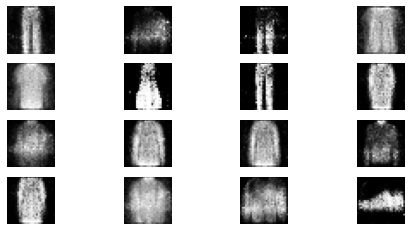

 44%|████▍     | 22/50 [03:35<04:27,  9.56s/it]

Time for epoch 22 is 9.473740577697754 sec
Training started with  epoch 23 with 469 batches...
Losses after epoch    23: generator 1.761, discriminator 0.850, real_score 76.57%, fake_score 25.19%


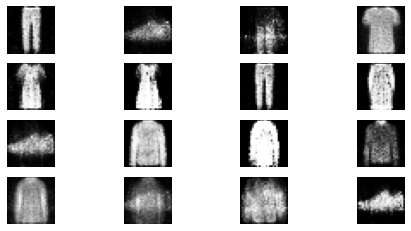

 46%|████▌     | 23/50 [03:46<04:27,  9.92s/it]

Time for epoch 23 is 10.770081043243408 sec
Training started with  epoch 24 with 469 batches...
Losses after epoch    24: generator 1.892, discriminator 0.716, real_score 74.55%, fake_score 23.31%


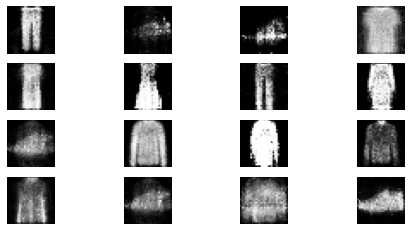

 48%|████▊     | 24/50 [03:56<04:12,  9.73s/it]

Time for epoch 24 is 9.271065711975098 sec
Training started with  epoch 25 with 469 batches...
Losses after epoch    25: generator 2.412, discriminator 0.672, real_score 78.41%, fake_score 18.57%


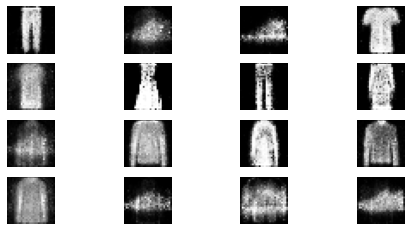

 50%|█████     | 25/50 [04:05<03:59,  9.58s/it]

Time for epoch 25 is 9.220375061035156 sec
Training started with  epoch 26 with 469 batches...
Losses after epoch    26: generator 2.010, discriminator 0.768, real_score 80.09%, fake_score 23.86%


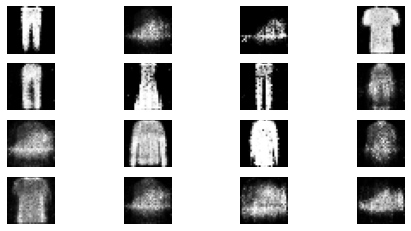

 52%|█████▏    | 26/50 [04:14<03:48,  9.52s/it]

Time for epoch 26 is 9.38158893585205 sec
Training started with  epoch 27 with 469 batches...
Losses after epoch    27: generator 2.102, discriminator 0.905, real_score 74.01%, fake_score 22.14%


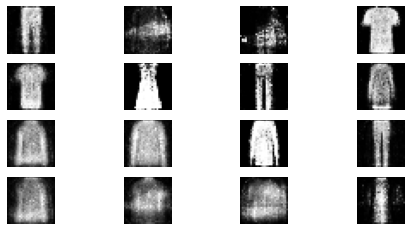

 54%|█████▍    | 27/50 [04:24<03:40,  9.57s/it]

Time for epoch 27 is 9.675890445709229 sec
Training started with  epoch 28 with 469 batches...
Losses after epoch    28: generator 1.013, discriminator 1.226, real_score 69.94%, fake_score 43.99%


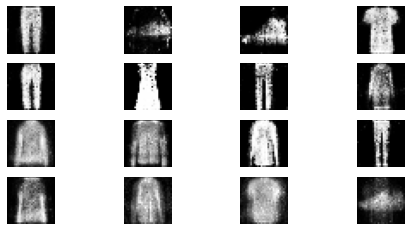

 56%|█████▌    | 28/50 [04:33<03:29,  9.53s/it]

Time for epoch 28 is 9.434601068496704 sec
Training started with  epoch 29 with 469 batches...
Losses after epoch    29: generator 1.618, discriminator 0.806, real_score 76.29%, fake_score 28.55%


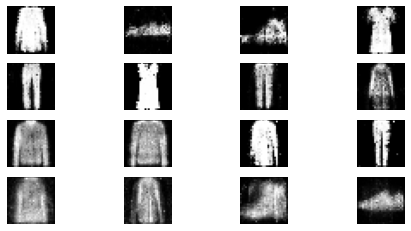

 58%|█████▊    | 29/50 [04:43<03:19,  9.51s/it]

Time for epoch 29 is 9.46333909034729 sec
Training started with  epoch 30 with 469 batches...
Losses after epoch    30: generator 2.811, discriminator 0.451, real_score 84.72%, fake_score 13.56%


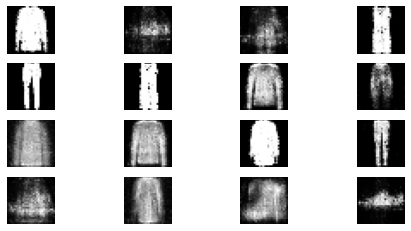

 60%|██████    | 30/50 [04:52<03:10,  9.51s/it]

Time for epoch 30 is 9.511447191238403 sec
Training started with  epoch 31 with 469 batches...
Losses after epoch    31: generator 2.428, discriminator 0.479, real_score 89.44%, fake_score 19.59%


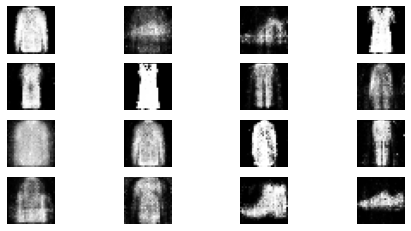

 62%|██████▏   | 31/50 [05:02<03:02,  9.59s/it]

Time for epoch 31 is 9.757688522338867 sec
Training started with  epoch 32 with 469 batches...
Losses after epoch    32: generator 2.739, discriminator 0.432, real_score 83.04%, fake_score 13.17%


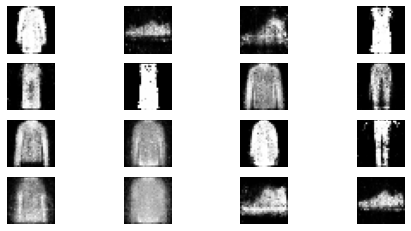

 64%|██████▍   | 32/50 [05:11<02:51,  9.53s/it]

Time for epoch 32 is 9.388972520828247 sec
Training started with  epoch 33 with 469 batches...
Losses after epoch    33: generator 2.335, discriminator 0.556, real_score 86.67%, fake_score 19.82%


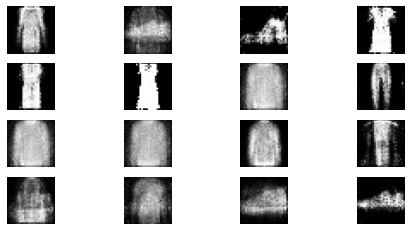

 66%|██████▌   | 33/50 [05:21<02:41,  9.51s/it]

Time for epoch 33 is 9.464713335037231 sec
Training started with  epoch 34 with 469 batches...
Losses after epoch    34: generator 1.921, discriminator 0.786, real_score 71.50%, fake_score 21.15%


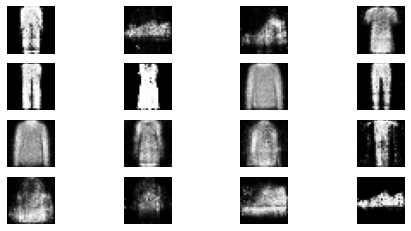

 68%|██████▊   | 34/50 [05:31<02:33,  9.59s/it]

Time for epoch 34 is 9.761211633682251 sec
Training started with  epoch 35 with 469 batches...
Losses after epoch    35: generator 1.398, discriminator 1.341, real_score 72.84%, fake_score 35.02%


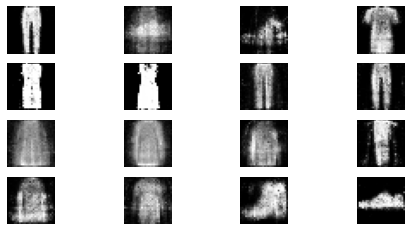

 70%|███████   | 35/50 [05:40<02:23,  9.58s/it]

Time for epoch 35 is 9.548049688339233 sec
Training started with  epoch 36 with 469 batches...
Losses after epoch    36: generator 1.646, discriminator 0.756, real_score 74.98%, fake_score 25.94%


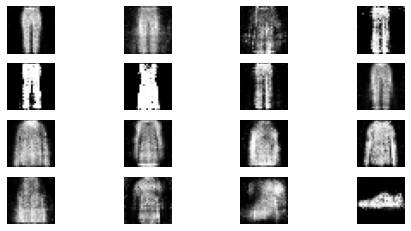

 72%|███████▏  | 36/50 [05:50<02:13,  9.54s/it]

Time for epoch 36 is 9.425141334533691 sec
Training started with  epoch 37 with 469 batches...
Losses after epoch    37: generator 1.561, discriminator 1.045, real_score 76.75%, fake_score 33.65%


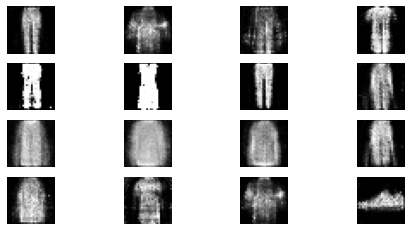

 74%|███████▍  | 37/50 [05:59<02:03,  9.52s/it]

Time for epoch 37 is 9.471999168395996 sec
Training started with  epoch 38 with 469 batches...
Losses after epoch    38: generator 1.691, discriminator 0.683, real_score 78.64%, fake_score 25.38%


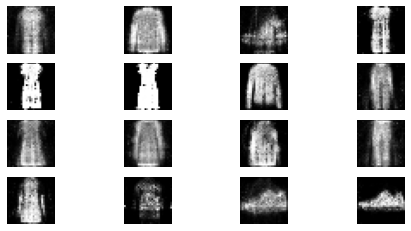

 76%|███████▌  | 38/50 [06:09<01:55,  9.59s/it]

Time for epoch 38 is 9.746415615081787 sec
Training started with  epoch 39 with 469 batches...
Losses after epoch    39: generator 2.489, discriminator 0.852, real_score 81.77%, fake_score 22.81%


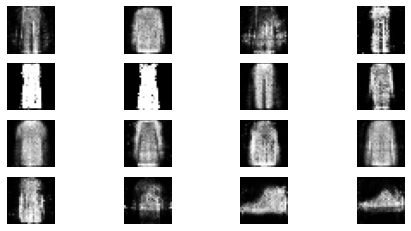

 78%|███████▊  | 39/50 [06:18<01:44,  9.53s/it]

Time for epoch 39 is 9.389552593231201 sec
Training started with  epoch 40 with 469 batches...
Losses after epoch    40: generator 2.753, discriminator 0.548, real_score 88.69%, fake_score 19.38%


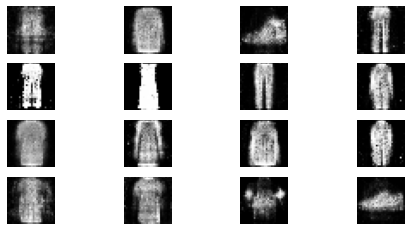

 80%|████████  | 40/50 [06:28<01:35,  9.51s/it]

Time for epoch 40 is 9.439435005187988 sec
Training started with  epoch 41 with 469 batches...
Losses after epoch    41: generator 1.316, discriminator 1.450, real_score 58.89%, fake_score 37.68%


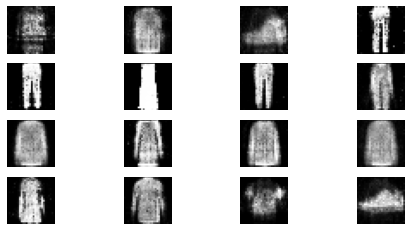

 82%|████████▏ | 41/50 [06:37<01:25,  9.50s/it]

Time for epoch 41 is 9.468102216720581 sec
Training started with  epoch 42 with 469 batches...
Losses after epoch    42: generator 2.066, discriminator 0.642, real_score 78.23%, fake_score 21.94%


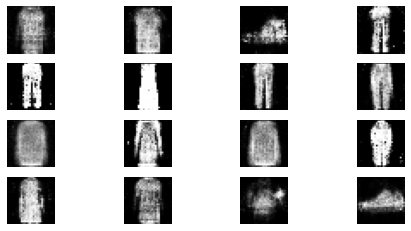

 84%|████████▍ | 42/50 [06:47<01:16,  9.53s/it]

Time for epoch 42 is 9.598014116287231 sec
Training started with  epoch 43 with 469 batches...
Losses after epoch    43: generator 1.581, discriminator 1.425, real_score 63.85%, fake_score 35.16%


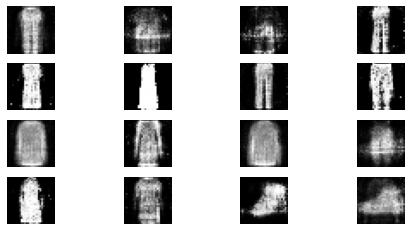

 86%|████████▌ | 43/50 [06:57<01:08,  9.74s/it]

Time for epoch 43 is 10.233731985092163 sec
Training started with  epoch 44 with 469 batches...
Losses after epoch    44: generator 1.459, discriminator 1.227, real_score 66.71%, fake_score 34.39%


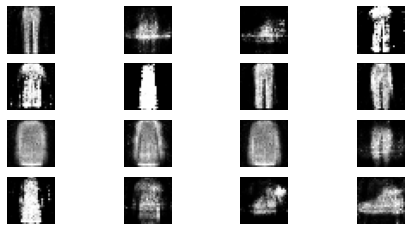

 88%|████████▊ | 44/50 [07:06<00:57,  9.64s/it]

Time for epoch 44 is 9.379708051681519 sec
Training started with  epoch 45 with 469 batches...
Losses after epoch    45: generator 2.081, discriminator 0.729, real_score 74.18%, fake_score 21.38%


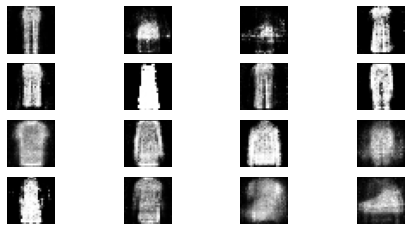

 90%|█████████ | 45/50 [07:16<00:48,  9.67s/it]

Time for epoch 45 is 9.728837728500366 sec
Training started with  epoch 46 with 469 batches...
Losses after epoch    46: generator 1.157, discriminator 1.028, real_score 73.37%, fake_score 39.30%


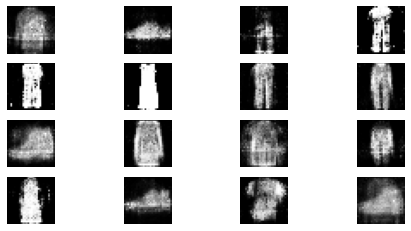

 92%|█████████▏| 46/50 [07:26<00:38,  9.63s/it]

Time for epoch 46 is 9.544626951217651 sec
Training started with  epoch 47 with 469 batches...
Losses after epoch    47: generator 1.785, discriminator 0.804, real_score 79.11%, fake_score 29.24%


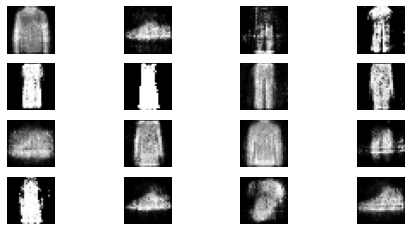

 94%|█████████▍| 47/50 [07:35<00:28,  9.59s/it]

Time for epoch 47 is 9.4879629611969 sec
Training started with  epoch 48 with 469 batches...
Losses after epoch    48: generator 2.724, discriminator 0.433, real_score 86.10%, fake_score 15.43%


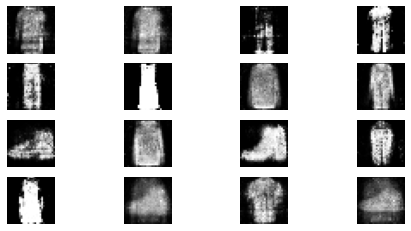

 96%|█████████▌| 48/50 [07:45<00:19,  9.52s/it]

Time for epoch 48 is 9.335039138793945 sec
Training started with  epoch 49 with 469 batches...
Losses after epoch    49: generator 2.443, discriminator 0.566, real_score 80.14%, fake_score 18.21%


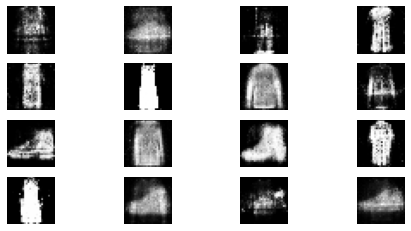

 98%|█████████▊| 49/50 [07:54<00:09,  9.57s/it]

Time for epoch 49 is 9.680440902709961 sec
Training started with  epoch 50 with 469 batches...
Losses after epoch    50: generator 2.506, discriminator 0.812, real_score 70.71%, fake_score 16.81%


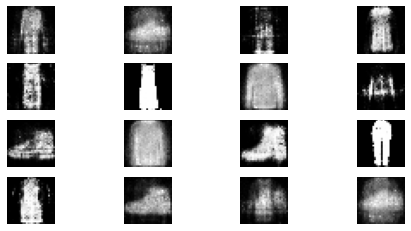

100%|██████████| 50/50 [08:04<00:00,  9.69s/it]

Time for epoch 50 is 9.538256883621216 sec


In [54]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

Plotting visualisations for Losses and Scores

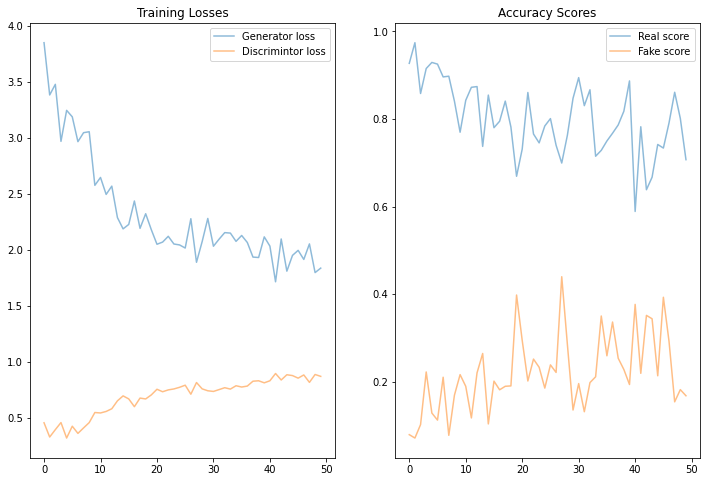

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()